<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recipe-Cuisine-Part-1---Binary-Classification" data-toc-modified-id="Recipe-Cuisine-Part-1---Binary-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recipe Cuisine Part 1 - Binary Classification</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Why-a-Binary-model-first" data-toc-modified-id="Why-a-Binary-model-first-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Why a Binary model first</a></span></li><li><span><a href="#Italian-and-Indian---polar-opposites?" data-toc-modified-id="Italian-and-Indian---polar-opposites?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Italian and Indian - polar opposites?</a></span></li><li><span><a href="#Words-to-Remove" data-toc-modified-id="Words-to-Remove-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Words to Remove</a></span><ul class="toc-item"><li><span><a href="#Parsing-rules-for-ingredients" data-toc-modified-id="Parsing-rules-for-ingredients-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Parsing rules for ingredients</a></span></li><li><span><a href="#Easy-method-of-removing-&quot;useless&quot;-words" data-toc-modified-id="Easy-method-of-removing-&quot;useless&quot;-words-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Easy method of removing "useless" words</a></span></li></ul></li><li><span><a href="#Converting-recipes-to-a-&quot;BagofWords&quot;" data-toc-modified-id="Converting-recipes-to-a-&quot;BagofWords&quot;-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Converting recipes to a "BagofWords"</a></span></li><li><span><a href="#Visualizing-the-class-balance" data-toc-modified-id="Visualizing-the-class-balance-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Visualizing the class balance</a></span></li><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Naive Bayes</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Using-a-pipeline-to-Kfold-Cross-validation" data-toc-modified-id="Using-a-pipeline-to-Kfold-Cross-validation-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Using a pipeline to Kfold Cross validation</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Appendix</a></span></li></ul></li></ul></div>

# Recipe Cuisine Part 1 - Binary Classification

## Introduction
This is part 1 of 2 notebooks that details the text processing, model training, evaluation and comparison of a recipe classifier.  The goal was to come up with a final model to deploy in AWS. 

I used AWS lambda functions to scrape for the recipes - this work and the pipeline in AWS is explained outside of these notebooks. (link).  I then exported that data out of AWS, to CSV files, which I use to work with locally.

## Why a Binary model first
To get started and find out if it was worth moving forward with this project - to use lambda functions to scrape recipes from a website, come up with a multicuisine classifier, deploy the model, and schedule a scraper 
## Italian and Indian - polar opposites?
First attempt will be using indian and italian recipes, come up with rules to preprocess the ingredient list, and try out a simple BagofWords classifcation model. I start with Italian and Indian, as they seem to be contrasting cuisines for an easier problem, and the amount of recipes for these cuisines available were the highest.

I chose [AllRecipes.com](https://www.allrecipes.com) since it is popular, has a decent amount of contributions for a variety of cuisines, and has [moderation](https://www.wikihow.com/Submit-a-New-Recipe-to-Allrecipes) before the recipe is submitted. 

In [53]:
import pandas as pd
import numpy as np
import ast
import string
import nltk
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold
from sklearn.pipeline import Pipeline

## Words to Remove
Weigths and measures are the type of words that will not add value to the model (unless I was considering quantity as a feature, not just the ingredient word). 
I lemmatize, and do not stem words, because I want real word ingredients.


In [54]:
#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['litrbes','liter','millilitres','mL','grams','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','c','pottle','gill','dram','wineglass','coffeespoon','pound','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium']
lemmatizer = WordNetLemmatizer()

measures = [lemmatizer.lemmatize(m) for m in measures]


### Parsing rules for ingredients
I implement rules in the function below. It removes any punctuation, numbers, converts the text to lowercase, lemmatizes the words, and finally, joins the parsed ingredients as a list.

In [55]:
recipes = []
cuisine_labels = []
ingredients = []
bi_ingredients = []


def parse_recipes(cuisine, recipe_series):

    for recipe in recipe_series.iteritems():
        ingr_set=ast.literal_eval(recipe[1])
        #print(ingr_set)
        ingr_list=[]
        for i in ingr_set:

            i.translate(str.maketrans('', '', string.punctuation))
            words=i.split()
            words = [''.join(c for c in word if c not in string.punctuation) for word in words]
            words = [word for word in words if word.isalpha()]
            words = [word.lower() for word in words]
            words = [lemmatizer.lemmatize(word) for word in words]
            words = [word for word in words if word not in measures]
            #print(words)
            #recipes.append(words)
            ingr_list.append(' '.join(words))
            
            
            bigrm = list(nltk.bigrams(words))
            #print(bigrm)
            bi_ingredients.append(bigrm)
            for word in words:
                ingredients.append(word)
        recipes.append(ingr_list)
        cuisine_labels.append(cuisine)


In [56]:
#load the recipes from the DynamoDB CSV exports
indian=pd.read_csv("recipes_indian.csv")
italian=pd.read_csv("recipes_italian.csv")

#parse them
parse_recipes('indian', indian['ingredients'])
parse_recipes('italian', italian['ingredients'])

### Easy method of removing "useless" words
There are advanced NLP techniques to recognize the entity of a word that would calculate the probality that a word is the ingredient, while the rest are measures, textures, actions and other types of words that surround the ingredient word.
A list of ingredients are not typical language sentences, and this method is effective as the results will show.

In [57]:
#show the most common ingredients collected, create a list of words to remove to add to the above function.

print("Total ingredients {0}, unique ingredients={1} total recipes {2}".format(len(ingredients), len(set(ingredients)),len(recipes)))
fdist = nltk.FreqDist(ingredients)
for word, frequency in fdist.most_common(15):
    print(u'{};{}'.format(word, frequency))
    

Total ingredients 90677, unique ingredients=1894 total recipes 3307
pepper;2762
ground;2591
cheese;2259
salt;2229
oil;2193
to;2134
taste;2073
and;1853
garlic;1836
olive;1711
tomato;1636
onion;1546
or;1387
black;1362
can;1320


In [58]:
#most frequent word tokens collected that I am removing by eyeball inspection first pass
#from most frequent so far
common_remove=['ground','to','taste', 'and', 'or', 'powder','black','white','red','green','yellow', 'can', 'seed', 'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','juice','dry','breast','extract','yellow','thinly','boneless','skinless','cubed','bell','bunch','cube','slice','pod','beaten','seeded','broth','uncooked','root','plain','baking','heavy','halved','crumbled','sweet','with','hot','confectioner','room','temperature','trimmed','allpurpose','sauce','crumb','deveined','bulk','seasoning','jar','food','sundried','italianstyle','if','bag','mix','in','each','roll','instant','double',
'such','extravirgin','frying','thawed','whipping','stock','rinsed','mild','sprig','brown','freshly','toasted','link','boiling','cooked','basmati','unsalted','container','split',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','gingergarlic','floret','coarsely','the','clarified','blanched','zested','sweetened','powdered','longgrain','garnish','indian','dressing','soup','at','active','french','lean','chip','sour','condensed','long','smoked','ripe','skinned','fillet','from','stem','flaked','removed','zest','stalk','unsweetened','baby','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring']
common_remove = [lemmatizer.lemmatize(c) for c in common_remove]

In [59]:
# repeat parse recipes with common_remove added to measures list, then I can reuse the function

recipes = []
cuisine_labels = []
ingredients = []
bi_ingredients = []
measures.extend(common_remove)

#parse them second round
parse_recipes('indian', indian['ingredients'])
parse_recipes('italian', italian['ingredients'])

print("Total ingredients {0}, unique ingredients={1} total recipes {2}".format(len(ingredients), len(set(ingredients)),len(recipes)))
fdist = nltk.FreqDist(ingredients)
for word, frequency in fdist.most_common(15):
    print(u'{};{}'.format(word, frequency))
    
#much improvement in the ingredient names, and reduction of potential features
# fdist = nltk.FreqDist(bi_ingredients)
# for word, frequency in fdist.most_common(10):
#     print(u'{};{}'.format(word, frequency))
#print(bi_ingredients)    

Total ingredients 50293, unique ingredients=1741 total recipes 3307
pepper;2762
cheese;2259
salt;2229
oil;2193
garlic;1836
olive;1711
tomato;1636
onion;1546
water;952
sugar;859
parmesan;820
egg;793
butter;756
chicken;752
basil;728


## Converting recipes to a "BagofWords"
The recipes are changed from a list of lists to a list of strings to make "recipe documents".  The `CountVectorizer` is used to create a matrix of the words from the training set.  Both the training and testing data are transofrmed into the BoW or _document-term matrix_ which will be input to the model.

In [60]:
#bagofwords or 'document-term matrix'
# recipes[0]
# cuisine_labels[0]

#change the list of lists, to list of strings (docs)
recipe_strings=[]
for r in recipes:
    recipe_strings.append(' '.join(r))

recipe_strings[0]
    # recipes=[''.join(x) for x in recipes]
# print(recipes[:4])
X_train, X_test, y_train, y_test = train_test_split(recipe_strings, cuisine_labels, test_size=0.25, stratify=cuisine_labels)

from sklearn.feature_extraction.text import CountVectorizer

#print(X_train)
vectorizer = CountVectorizer()

matrix_train=vectorizer.fit_transform(X_train)

matrix_test=vectorizer.transform(X_test)

#print(vectorizer.vocabulary_)


len(vectorizer.get_feature_names())
# for r in recipe_strings:
#         words = word_extraction(r)
#         bag_vector = numpy.zeros(len(vocab))
#         for w in words:
#             for i,word in enumerate(vocab):
#                 if word == w: 
#                     bag_vector[i] += 1
                    
#         print("{0}\n{1}\n".format(sentence,numpy.array(bag_vector)))
        
        

1558

## Visualizing the class balance
There are over 3 times more Italian than Indian recipes.  Is it enough data for an ML model to learn what is Indian?  Will the ML do better than 76% (a Dummy classifier where every recipe is classified as Italian)  

[787, 2520]


Text(0.5, 1.0, 'Cuisine (Class) Counts')

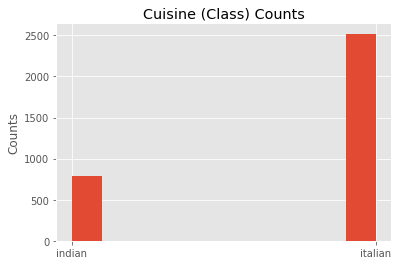

In [61]:
#plot the class counts as a bar chart
from collections import Counter

cuisine_counts = Counter(cuisine_labels)
print(list(cuisine_counts.values()))

plt.hist(list(cuisine_counts.keys()), weights=list(cuisine_counts.values()))
plt.ylabel('Counts')
plt.title('Cuisine (Class) Counts')

## Naive Bayes
From the book. It is a simple model and fast.

In [62]:
cuisines=['indian', 'italian']
losses = []
auc = []

from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(matrix_train, y_train)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = nb_clf.predict(matrix_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cuisines))
print(confusion_matrix(y_test, y_pred))

 

print("results of using the model on the training data:")
y_pred_train = nb_clf.predict(matrix_train)
print('accuracy %s' % accuracy_score(y_pred_train, y_train))
print(classification_report(y_train, y_pred_train,target_names=cuisines))
print(confusion_matrix(y_train, y_pred_train))

neg_class_prob_sorted = (-nb_clf.feature_log_prob_[0, :]).argsort()     #Note : Putting a - sign indicates the indexes will be sorted in descending order.
pos_class_prob_sorted = (-nb_clf.feature_log_prob_[1, :]).argsort()

neg_class_features = np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:50])
pos_class_features = np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:50])

print("The top 50 most frequent words from the Italian class are :\n")
print(pos_class_features)

print("\nThe top 50 most frequent words from the Indian class are :\n")
print(neg_class_features)

#What was misclassified in the test set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_pred):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set**:\n")
for m in misclassifiedIndexes[:10]:
    print("{0} classified as {1}:\n{2}\n".format(y_test[m],y_pred[m],X_test[m]))
#print(y_test[:5], y_pred[:5])

index = 0
misclassifiedIndexes = []
for label, predict in zip(y_train, y_pred_train):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(y_train[m],y_pred_train[m],X_train[m]))
    

accuracy 0.9842805320435308
              precision    recall  f1-score   support

      indian       0.96      0.97      0.97       197
     italian       0.99      0.99      0.99       630

    accuracy                           0.98       827
   macro avg       0.98      0.98      0.98       827
weighted avg       0.98      0.98      0.98       827

[[191   6]
 [  7 623]]
results of using the model on the training data:
accuracy 0.9838709677419355
              precision    recall  f1-score   support

      indian       0.96      0.97      0.97       590
     italian       0.99      0.99      0.99      1890

    accuracy                           0.98      2480
   macro avg       0.98      0.98      0.98      2480
weighted avg       0.98      0.98      0.98      2480

[[ 571   19]
 [  21 1869]]
The top 50 most frequent words from the Italian class are :

['cheese' 'pepper' 'oil' 'salt' 'olive' 'garlic' 'tomato' 'onion'
 'parmesan' 'egg' 'basil' 'sugar' 'italian' 'chicken' 'water' 'b

## Results

Pretty good! Almost "perfect" for both cuisines on the training and testing sets. The information above also helps me think of ideas for the multiclass problem, such as bigrams to help deal with overlap of ingredients in cuisine.

## Using a pipeline to Kfold Cross validation
Results are consistent for each fold, for both training and testing

In [63]:
clf_pipe = Pipeline([('vect', CountVectorizer()), ('mnb', MultinomialNB())])
skf=StratifiedKFold(n_splits=3)

cross_validate(clf_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf )

{'fit_time': array([0.03628492, 0.03484702, 0.03571463]),
 'score_time': array([0.01954198, 0.01862383, 0.0195241 ]),
 'test_score': array([0.98459752, 0.98551861, 0.98093119])}

## Appendix

Demonstration using the "From the Deep Learning with Python" book.  Deep Learning is not worth the cost and won't get any better than the simple model, except for the possible score of 100% on both train and test if I kept the training going ...

The results below show after 7/8 epochs using the basic Dense model using Keras with two layers, the gains increase at a much slower rate.

In [64]:
from keras import models
from keras import layers
model = models.Sequential()
#.9734 for one layer (16)
model.add(layers.Dense(64, activation='relu', input_shape=(1563,)))
# two layers .9758 (16)
model.add(layers.Dense(64, activation='relu'))
#trying a third .977 (16)
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [65]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras import utils

max_words = 1563
tokenizer = Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)

X_train_t = tokenizer.texts_to_matrix(X_train)
X_test_t = tokenizer.texts_to_matrix(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_t = encoder.transform(y_train)
y_test_t = encoder.transform(y_test)



In [66]:
from keras import optimizers
        
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history = model.fit(X_train_t, y_train_t,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test_t, y_test_t))

history_dict = history.history

Train on 2480 samples, validate on 827 samples
Epoch 1/20
2480/2480 [==============================] - 1s 529us/step - loss: 0.6167 - acc: 0.7097 - val_loss: 0.5032 - val_acc: 0.7969
Epoch 2/20
2480/2480 [==============================] - 1s 211us/step - loss: 0.4363 - acc: 0.8476 - val_loss: 0.3513 - val_acc: 0.9093
Epoch 3/20
2480/2480 [==============================] - 0s 193us/step - loss: 0.2968 - acc: 0.9359 - val_loss: 0.2424 - val_acc: 0.9553
Epoch 4/20
2480/2480 [==============================] - 0s 187us/step - loss: 0.2010 - acc: 0.9685 - val_loss: 0.1743 - val_acc: 0.9686
Epoch 5/20
2480/2480 [==============================] - 0s 186us/step - loss: 0.1423 - acc: 0.9798 - val_loss: 0.1341 - val_acc: 0.9770
Epoch 6/20
2480/2480 [==============================] - 0s 187us/step - loss: 0.1055 - acc: 0.9843 - val_loss: 0.1089 - val_acc: 0.9794
Epoch 7/20
2480/2480 [==============================] - 0s 185us/step - loss: 0.0816 - acc: 0.9871 - val_loss: 0.0921 - val_acc: 0.9807
E

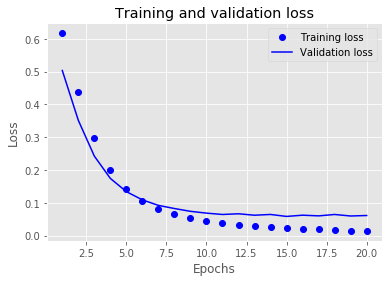

In [67]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

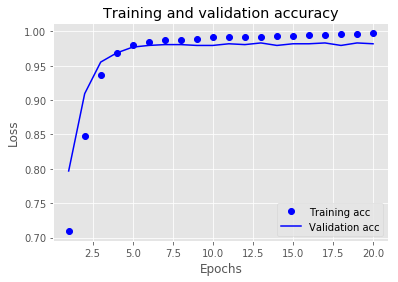

In [68]:
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()